# **20230523**

In [1]:
import xgboost

print(xgboost.__version__)

1.7.5


### O 파이썬 래퍼 XGBoost 하이퍼 파라미터

- 일반 파라미터

- 부스터 파라미터 

- 학습 태스크 파라미터

#### ㅇ 주요 일반 파라미터

- booster : gbree or gblinear   , default=gbtree
- silent : default=0, 출력메세지 원치 않으면 1
- **nthread** : CPU 실행 스레드 개수 조정, default=전체 사용

#### ㅇ 주요 부스터 파라미터

- eta(learning rate) : default=0.3 , 학습률. 0~1사이 , 0.01~0.02 사이 값 선호
- num_boost_rounds : n_estimater
- min_child_weight : default=1, 과적합 규제
- gamma : default=0, 트리의 리프 노드를 추가적으로 나눌지 결정할 최소 손실 감소 값, 클수록 과대적합 감소효과
- max_depth : default=6, 0~ 깊이 제한 x
- sub_samples : 일반적으로0.5~1 값
- colsample_bytree: default=1 , max_feature
- **lambda**: default=1,  피처 개수가 많을 경우 적용을 검토하여 값이 클수록 과적합 감소 효과
- **alpha** : default=0, 피처 개수가 많을 경우 적용을 검토하여 값이 클수록 과적합 감소 효과
- scale_pos_weight : default=1, 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한

--- 

# **20230524**

#### ㅇ 학습 태스크 파라미터

|파라미터| 설명 / value |
|:-----:|---|
| objective | 최솟값을 가져야 할 **cost function 정의**, 회귀or분류(이진/다중) 지정 /<br> - **binary:logistic** : 이진분류일때 적용 [1-{log(P) - log(1-P)}]<br> - **multi:softmax** : 다중분류일 때 적용 , num_class 파라미터 지정해야함 <br> - **multi:softprob** : multi:softmax 와 유사, 개별 레이블  클래스의 해당되는 예측 *확률* 반환|
| eval_metric <br> (검증 방법)| 검증(성능평가)에 사용되는 함수를 정의, default=(회귀:rmse\|분류:error) <br> - **rmse** : Root Mean Square Error 루트(오차 제곱의 평균) <br> - mae : Mean Absolute Error (절대값 오차의 평균) <br> - logloss : Negative log-likelihood(가능도) <br> - **error** : Binary classificaion error rate (0.5 threshold) <br> - **merror** : Multiclass calssification error rate <br> - mlogloss : Muliclass logloss <br> - **auc** : Area under the curve (분류에서 불균형 데이터셋일 때)|


+) error=cost=loss

+) 확률 = 확률분포에서 해당 관측값이 나올 확률 <br>
+) 가능도(likelihood) = 주어진 관측값에서 이것이 해당 확률분포에 나왔을 확률(평균과 가까울 때 가장 높음) => 높을 수록 데이터

#### ㅇ 과적합 문제가 심할 때

- eta 값을 낮춘다(0.01~0.1) and num_round(n_estimators) 높히기
- max_depth 값을 낮춘다
- min_child_weight 값을 높힌다.
- gamma 값을 높힌다 (규제함-> 일반화성능 상승)
- subsample, colsample_bytree 조정

XGBoost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능 가지고 있음, 

수행속도 향상을 위해 조기중단 기능이 있음

### O 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측 



In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 유방암 데이터 로딩 => DataFrame으로 생성

dataset = load_breast_cancer()
X_features= dataset.data    # 데이터
y_label = dataset.target    # 답

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label # 답 처리
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
# 데이터 분포 확인 => 스케일링 진행 여부 파악
cancer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [6]:
# 데이터(레이블-target column) 불균형성 확인

# malignant(0) : 악성 종양 / benign(1) : 양성 종양

print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


##### 데이터 프레임에서 데이터와 답 분리

In [7]:
X_features = cancer_df.iloc[:, :-1] # 전체 행, 마지막 컬럼 제외 다
y_label = cancer_df.iloc[:, -1]     # 전체 행, 마지막 컬럼만

##### 학습/검증/테스트 데이터 분리

In [8]:
# 1) 학습(X_train, y_train)/테스트(X_test, y_test) 분리

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

In [9]:
# 2) 학습 => 학습/검증 분리
 
 
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train
                                        , test_size=0.1, random_state=156 )

In [10]:
# 3) shape 확인

print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)


(455, 30) (114, 30)
(409, 30) (46, 30)


##### DMatrix

In [11]:
# XGBoost data type 존재
# DMatrix class => 기존 데이터 넣고 학습
# 주목적 :  학습 속도 향상

# 학습, 검증, 테스트용 DMatrix를 생성.

# DataFrame => ndarray=> DMatrix 변환
dtr = xgb.DMatrix(data=X_tr, label=y_tr)        # X_tr, y_tr: 학습용
dval = xgb.DMatrix(data=X_val, label=y_val)     # X_val, y_val : 검증용
dtest = xgb.DMatrix(data=X_test , label=y_test) # X_test, y_test: 테스트용

##### 파라미터 설정

In [12]:
# 파라미터 설정

params = { 'max_depth':3,               # 트리 깊이
          'eta': 0.05,                  # 학습률
          'objective':'binary:logistic',# 이진분류
          'eval_metric':'logloss'       # 검증방식(검증함수지정)
         }

num_rounds = 400                        # 트리 개수(n_estimators)


In [13]:
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 


# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params 
                      , dtrain=dtr 
                      , num_boost_round=num_rounds
                      , early_stopping_rounds=50
                      , evals=eval_list )

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

학습 종료됨 => 오차가 최소가 되는 가중치(W)를 구했다는 의미

##### 성능 검증 => 테스트 데이터

In [14]:
# 1. 예측 확률 추출
pred_probs = xgb_model.predict(dtest)

# 2. 예측 확률 추출 확인
print(np.round(pred_probs[:10],3))


[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]


In [15]:
# 3. 확률(0.5) 기준 분류 : 0,1

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])


예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
# 불균형 데이터셋

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [19]:
# 원래답, 예측값, 예측 확률
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


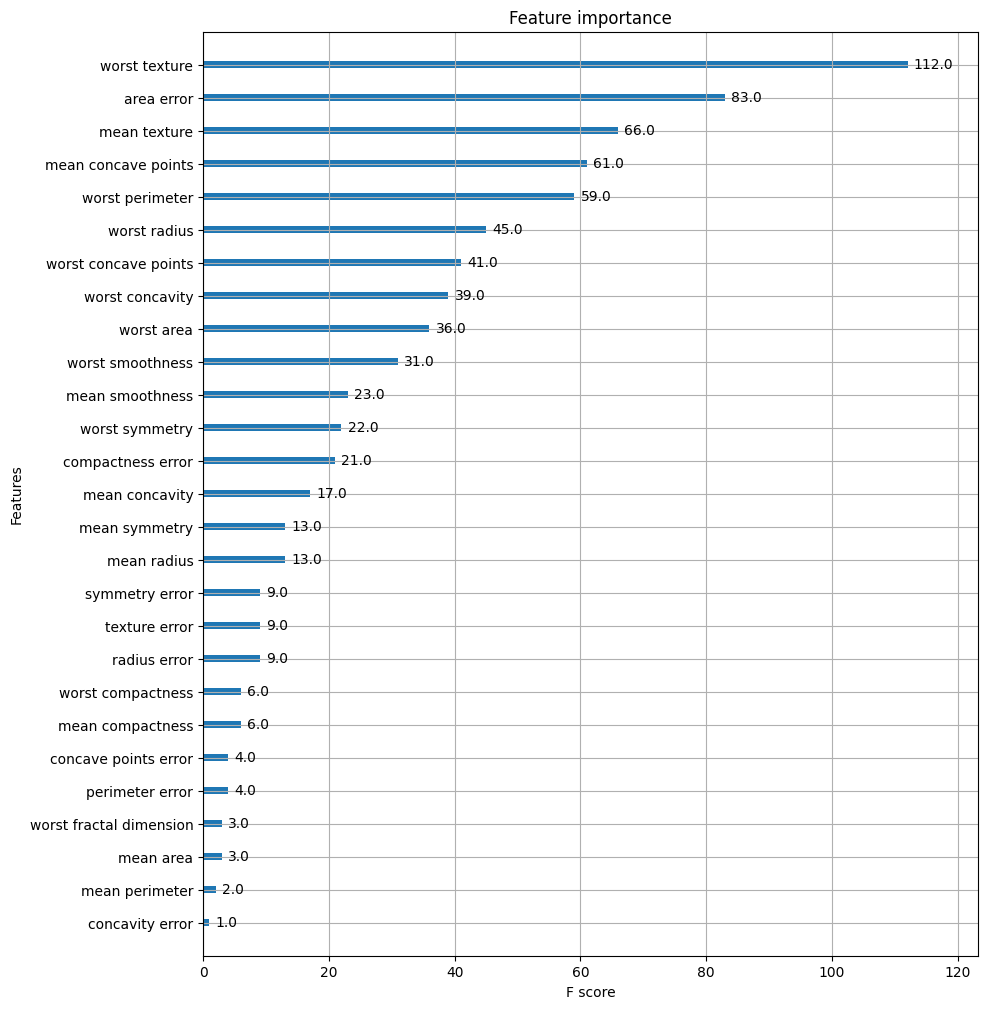

In [20]:
# 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

### O 사이킷런 래퍼 XGBoost의 개요 및 적용

fit, predict, GridSCV 가능

- 파이썬 -> 사이킷런<br>
- eta -> learning_rate<br>
- sub_sample -> subsample<br>
- lambda -> reg_lambda<br>
- alpha -> regalpha<br>


In [21]:
from xgboost import XGBClassifier


xgb_wrapper = XGBClassifier(n_estimators=400
                            , learning_rate=0.1 # 학습률
                            , max_depth=3
                            )

xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)           #예측값 추출
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]   # 예측 확률 추출


In [22]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


조기 중단 수행


In [51]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400
                            , learning_rate=0.1
                            , max_depth=3
                            )
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train
                , early_stopping_rounds=100
                , eval_metric="logloss"
                , eval_set=evals
                , verbose=True  # 결과 추출
                )

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [52]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954
